In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import os

In [2]:
events_prog = pd.read_csv('events_biomarkers.csv')

In [3]:
events_prog['PARK'] = (events_prog['APPRDX'] != 2).astype(int)
print(events_prog['PARK'].value_counts())

1    378
0    265
Name: PARK, dtype: int64


In [4]:
x_cols = events_prog.columns.drop(['YEAR', 'EVENT_ID', 'PATNO', 'Progression', 'hy', 'APPRDX', 'PARK', 'PD_MED_USE'])
events_x = events_prog[x_cols]
events_y = events_prog['PARK']

In [5]:
## Create train, test, valid sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(events_x, events_y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [6]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score

def select_best_model(train_X, train_y, valid_X, valid_y, C_options, penalty_options):
    best_model, best_C, best_penalty, best_score = None, None, None, 0 
    for C in C_options:
        for penalty in penalty_options:
            model = LogisticRegression(C=C, penalty=penalty).fit(train_X, train_y)
            train_pred = [p[1] for p in model.predict_proba(train_X)]
            train_auc = roc_auc_score(train_y, train_pred)
            valid_pred = [p[1] for p in model.predict_proba(valid_X)]
            valid_auc = roc_auc_score(valid_y, valid_pred)
            print("C=" + str(C) + " | p=" + penalty + " :: train AUC=" + str(train_auc) + " ; valid AUC=" + str(valid_auc))
            if valid_auc > best_score:
                best_model, best_C, best_penalty, best_score = model, C, penalty, valid_auc
    print("Best model: C = " + str(best_C) + ", penalty: " + str(best_penalty))
    return best_model

model = select_best_model(X_train, y_train, X_val, y_val, [0.1], ['l1'])
test_pred = [p[1] for p in model.predict_proba(X_test)]
print("test AUC: ", roc_auc_score(y_test, test_pred))

C=0.1 | p=l1 :: train AUC=0.9986905281536447 ; valid AUC=0.9987714987714988
Best model: C = 0.1, penalty: l1
test AUC:  0.9997530864197531


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


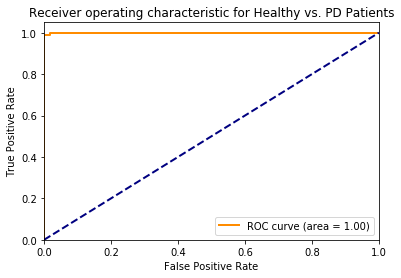

In [7]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Healthy vs. PD Patients')
plt.legend(loc="lower right")
plt.show()

In [8]:
def sort_features(model, features):
    coef = model.coef_
    feature_coef = [(features[i], coef[0,i]) for i in range(len(features))]
    sorted_feature_coef = sorted(feature_coef, key=lambda x: -x[1]) 
    return sorted_feature_coef

def display_most_predictive_features(sorted_features, n, positive=True): 
    if positive:
        for i in range(n):
            print(sorted_features[i][0] + ": " + str(sorted_features[i][1]))
    else:
        for i in range(len(sorted_features) - 1, len(sorted_features) - 1 - n, -1):
            print(sorted_features[i][0] + ": " + str(sorted_features[i][1]))

feat = sort_features(model, list(events_x.columns))
print("MOST POSIVITE ++")
display_most_predictive_features(feat, 10)
print()
print("MOST NEGATIVE --")
display_most_predictive_features(feat, 10, False)
print()
display_most_predictive_features(feat, 66)

MOST POSIVITE ++
updrs3_score: 0.5690802076036154
updrs_totscore: 0.1693675508773562
updrs2_score: 0.03932033940758185
SDMTOTAL: 0.032937886862998506
sft: 0.020437371913373286
abeta: 0.001370553864717256
Unnamed: 0: 0.0010513022707991657
APOE_e4: 0.0
EDUCYRS: 0.0
HISPLAT: 0.0

MOST NEGATIVE --
ess: -0.08357519808908867
stai_trait: -0.06687111295094739
age: -0.04209519294789277
updrs1_score: -0.03817699764542011
tau: -0.014273565817197749
urate: -0.006541957877177753
asyn: -0.0009266901129530594
race_other: 0.0
race_asian: 0.0
race_black: 0.0

updrs3_score: 0.5690802076036154
updrs_totscore: 0.1693675508773562
updrs2_score: 0.03932033940758185
SDMTOTAL: 0.032937886862998506
sft: 0.020437371913373286
abeta: 0.001370553864717256
Unnamed: 0: 0.0010513022707991657
APOE_e4: 0.0
EDUCYRS: 0.0
HISPLAT: 0.0
HVLTFPRL: 0.0
HVLTRDLY: 0.0
HVLTREC: 0.0
MAPT_cat: 0.0
NP1ANXS: 0.0
NP1APAT: 0.0
NP1COG: 0.0
NP1DDS: 0.0
NP1DPRS: 0.0
NP1FATG: 0.0
NP1HALL: 0.0
SNCA_rs356181_cat: 0.0
SNCA_rs3910105_cat: 0.0


In [9]:
events_prog['hy'].value_counts()

0    260
2    235
1    138
3     10
Name: hy, dtype: int64

In [10]:
# x_cols = events_prog.columns.drop(['YEAR', 'EVENT_ID', 'PATNO', 'Progression', 'hy', 'APPRDX', 'PARK'])
# events_stage_x = events_prog[x_cols]
# events_stage_y = events_prog['hy']

# X_train, X_test, y_train, y_test = train_test_split(events_stage_x, events_stage_y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# model = LogisticRegression(C=0.1, penalty='l1').fit(X_train, y_train)
# pred_mat = model.predict_proba(X_test)

# test_pred = [pred_mat[i][y_test.iloc[i]] for i in range(len(y_test))]
# print(test_pred)
    
# print("test AUC: ", roc_auc_score([1 for i in range(len(y_test))], test_pred))

[0.6063731088715499, 0.6265960039874398, 0.9252865670661984, 0.913683959200198, 0.35875559646702326, 0.5226719765825744, 0.9418746767583601, 0.9237982774837628, 0.2998354083936016, 0.9053438455980507, 0.3483962038624936, 0.9681206544323765, 0.8043670346543249, 0.7202259805903959, 0.08974192421746394, 0.5397794676028865, 0.9605549416175487, 0.665248249310618, 0.6618181483817355, 0.713550599756139, 0.7107858114508826, 0.9451991182824832, 0.47485090357846627, 0.9292524649007083, 0.980084681115895, 0.6380349105492155, 0.9366671572158319, 0.9730406676770452, 0.7767075284384677, 0.9254306522366941, 0.9337908936242723, 0.7455750763220006, 0.9133036117033325, 0.9922066072190897, 0.5395118676092058, 0.8217718072821704, 0.9088181414628562, 0.7361608818258214, 0.01112950358248529, 0.3046256563478575, 0.45538654149950497, 0.7230696945912223, 0.006330154883909395, 0.8872669114048591, 0.9780179106273508, 0.8591450039986102, 0.5627838555144038, 0.41698619374611323, 0.5231916822707091, 0.8724150449111

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

X = events_stage_x
y = events_stage_y

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [12]:
print(roc_auc)

{0: 0.9916266025641025, 1: 0.6364543926019336, 2: 0.8989350141273635, 3: 0.6730158730158731}


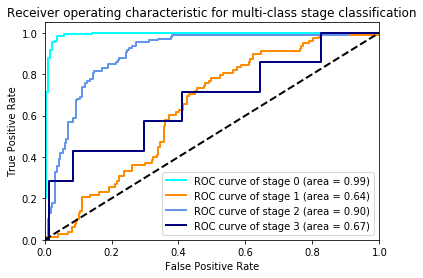

In [13]:
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
lw = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of stage {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class stage classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classifier._coef)